In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import constants as cnst
import os
from IPython.display import Markdown as md
import matplotlib.ticker as mticker


## Load data

In [5]:
datadir	= './postproc_data/'
scens	= ['35','70','140','280','560','1120','2240']
scens	= xr.DataArray(scens, coords=[('scenario',scens)])
fluxes	= {flx: [] for flx in ['bflux','bflux_T','bflux_q','bflux_qc','h_ex_SH','h_ex_LH','h_ex','h_rad','h_res']}
for i, scen in enumerate(scens.values):
    fname_hflx	= f'{datadir}CAM_hflux_glb_c{scen}.nc'
    fluxes['h_ex_LH'].append(xr.open_dataset(fname_hflx).latent_vol.mean('time'))
    fluxes['h_ex_SH'].append(xr.open_dataset(fname_hflx).sensible_vol.mean('time'))
    fluxes['h_ex'].append(xr.open_dataset(fname_hflx).total_vol.mean('time'))
    fname_bflux	= f'{datadir}CAM_bflux_glb_c{scen}.nc'
    fluxes['bflux'].append(xr.open_dataset(fname_bflux).total_vol.mean('time'))
    fluxes['bflux_T'].append(xr.open_dataset(fname_bflux).sens_vol.mean('time'))
    fluxes['bflux_q'].append(xr.open_dataset(fname_bflux).moist_vol.mean('time'))
    fluxes['bflux_qc'].append(xr.open_dataset(fname_bflux).cond_vol.mean('time'))
    fname_hbud    = f'{datadir}CAM_Ebud_glb_c{scen}.nc'
    hbud=xr.open_dataset(fname_hbud)
    fluxes['h_rad'].append(hbud.rad_vol.mean('time'))
    fluxes['h_res'].append((hbud.rad_vol+hbud.pbl_vol+hbud.sc_vol+hbud.dc_vol).mean('time')) 
#    fluxes['h_res'].append((hbud.rad_vol+hbud.dc_vol).mean('time')) 
for flx in list(fluxes.keys()):
	fluxes[flx]		= xr.concat(fluxes[flx], dim=scens)

fname_mon	= f'{datadir}CAM6_mon_glb.nc'
var_mon		= xr.open_dataset(fname_mon)

In [6]:
#   radiative forcing and ano.
co2_ref		= 280
forcing		= np.log(scens.astype(float)/co2_ref)
fluxes_ref	= {}
fluxes_ano	= {};		
for flx in list(fluxes.keys()):
	fluxes_ref[flx]	= fluxes[flx].sel(scenario=str(co2_ref))
	fluxes_ano[flx]	= fluxes[flx] - fluxes_ref[flx]

#	fractions
var_frac	= {flx: fluxes[flx]/fluxes_ref[flx] \
				for flx in list(fluxes.keys())}
bow			= fluxes['h_ex_SH']/fluxes['h_ex_LH']
bflux2      = fluxes['bflux_T']+fluxes['bflux_q']+0.*fluxes['bflux_qc']
var_frac['bow']		= bow/bow.sel(scenario=str(co2_ref))
var_frac['bflux2']	= bflux2/bflux2.sel(scenario=str(co2_ref))

#%%
alp			= 1005.7*260*0.61/2.5e6
FofB		= (alp + bow) / (1 + bow)
var_frac['FofB']	= FofB/FofB.sel(scenario=str(co2_ref))

#%%
#   gmst ano.
gmst_ano    = var_mon['TS'].mean('time') \
				- var_mon['TS'].mean('time').sel(scenario=str(co2_ref))


## Make Plots

In [7]:
#Some stuff for plot layout 
def	ax_frac_dts(ax, lgd=True, pltfact=1, tklbsize=12, xsize=2):
    if lgd:	ax.legend(fontsize=tklbsize)
    ax.grid()
    ax.axhline(1.*pltfact, c='grey', lw=1.75, zorder=1)
    ax.axvline(0., c='grey', lw=1.75, zorder=1)
    ax.set_xlabel(r'$\Delta \overline{T_s}$ (K)', size=tklbsize+xsize)
    ax.set_yticks([0.7,0.8, 0.9, 1.0,1.1,1.2,1.3,1.4])
    ax.tick_params(labelsize=tklbsize)
    ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

xlim 	= [-4.5,5.5]
ylim 	= [0.68,1.38]
pltfact=1
tklbsize=12
xsize=2

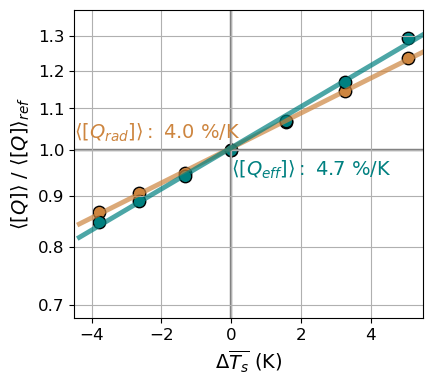

In [8]:
#   plot <[Q]> vs GMST
dotclr1	= 'peru'
dotclr2	= 'teal'
dotclr3	= 'black'
pltvar1 = var_frac['h_rad']*pltfact
pltvar2 = var_frac['h_res']*pltfact
pltvar3 = var_frac['h_ex']*pltfact
p1      = np.polyfit(gmst_ano, np.log(pltvar1), deg=1)
p2      = np.polyfit(gmst_ano, np.log(pltvar2), deg=1)
p3      = np.polyfit(gmst_ano, np.log(pltvar3), deg=1)
fig     = plt.figure(figsize=(4.5,4))
ax      = fig.add_subplot()
ax.semilogy(gmst_ano*1.15, np.exp(np.polyval(p1, gmst_ano*1.15)), lw=3.5, \
		c=dotclr1, alpha=.7)
ax.semilogy(gmst_ano*1.15, np.exp(np.polyval(p2, gmst_ano*1.15)), lw=3.5, \
		c=dotclr2, alpha=.7)
#ax.semilogy(gmst_ano*1.15, np.exp(np.polyval(p3, gmst_ano*1.15)), lw=1.5, \
#		c=dotclr3, alpha=.7)
ax.scatter(gmst_ano, pltvar1, s=80, facecolors=dotclr1, edgecolors='k')
ax.scatter(gmst_ano, pltvar2, s=80, facecolors=dotclr2, edgecolors='k')
#ax.scatter(gmst_ano, pltvar3, s=40, facecolors=dotclr3, edgecolors='k')
ax_frac_dts(ax, pltfact=pltfact, tklbsize=tklbsize, xsize=xsize, lgd=False)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.annotate(r'$\langle [Q_{rad}] \rangle :$ %.1f %%/K'%(p1[0]*1e2/pltfact),  xy=(0.0,0.6), xycoords='axes fraction',\
			ha='left', va='center', size=tklbsize+xsize, color=dotclr1)
ax.annotate(r'$\langle [Q_{eff}] \rangle :$ %.1f %%/K'%(p2[0]*1e2/pltfact),xy=(.45,.48), xycoords='axes fraction',\
			ha='left', va='center', size=tklbsize+xsize, color=dotclr2)
#ax.annotate('resolved (expl.) %.1f %%/K'%(p3[0]*1e2/pltfact), xy=(.1,.62), xycoords='axes fraction',\
#			ha='left', va='center', size=tklbsize+xsize, color=dotclr3)
ax.set_ylabel(r'$\left\langle [Q] \right\rangle$ / $\left\langle [Q] \right\rangle_{ref}$', size=tklbsize+xsize)
fig.savefig('scatter_MSEflx.png', dpi=600, bbox_inches='tight')
plt.show()

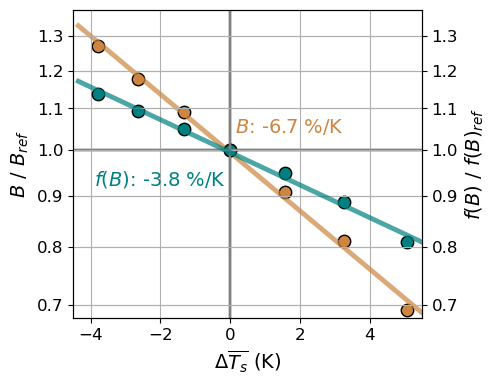

In [9]:
#  plot B and f(B) vs GMST
pltfact = 1
dotclr1	= 'peru'
dotclr2	= 'teal'
pltvar1 = var_frac['bow']*pltfact
pltvar2 = var_frac['FofB']*pltfact
p1      = np.polyfit(gmst_ano, np.log(pltvar1), deg=1)
p2      = np.polyfit(gmst_ano, np.log(pltvar2), deg=1)
fig, ax1 = plt.subplots(figsize=(4.5,4))
ax2     = ax1.twinx()
ax1.semilogy(gmst_ano*1.15, np.exp(np.polyval(p1, gmst_ano*1.15)), lw=3.5, \
		c=dotclr1, alpha=.7)
ax2.semilogy(gmst_ano*1.15, np.exp(np.polyval(p2, gmst_ano*1.15)), lw=3.5, \
		c=dotclr2, alpha=.7)
ax1.scatter(gmst_ano, pltvar1, s=80, facecolors=dotclr1, edgecolors='k')
ax2.scatter(gmst_ano, pltvar2, s=80, facecolors=dotclr2, edgecolors='k')
ax_frac_dts(ax1, pltfact=pltfact, tklbsize=tklbsize, xsize=xsize, lgd=False)
ax_frac_dts(ax2, pltfact=pltfact, tklbsize=tklbsize, xsize=xsize, lgd=False)
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax2.set_ylim(ylim)
ax1.annotate('$B$: %.1f %%/K'%(p1[0]*1e2/pltfact), xy=(.62,.62), xycoords='axes fraction',\
			ha='center', va='center', size=tklbsize+xsize, color=dotclr1)
ax2.annotate('$f(B)$: %.1f %%/K'%(p2[0]*1e2/pltfact), xy=(.25,.45), xycoords='axes fraction',\
			ha='center', va='center', size=tklbsize+xsize, color=dotclr2)
ax1.set_ylabel('$B$ / $B_{ref}$', size=tklbsize+xsize)
ax2.set_ylabel(r'$f(B)$ / $f(B)_{ref}$', size=tklbsize+xsize)
fig.savefig('scatter_bowen.png', dpi=600, bbox_inches='tight')
plt.show()

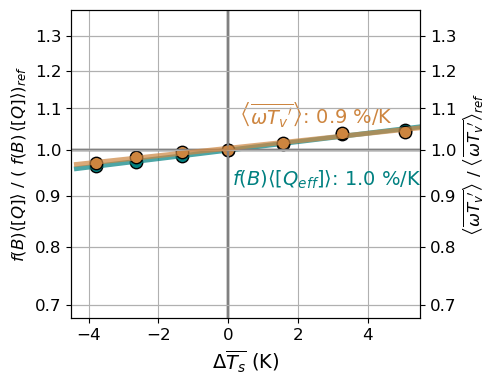

In [10]:
# Plot f(B)*<[Q]> and \bar{w'T_v'} vs GMST
dotclr1	= 'teal'
dotclr2	= 'peru'
pltvar1 = var_frac['FofB']*var_frac['h_res']*pltfact
#pltvar1 = var_frac['FofB']*var_frac['h_ex']*pltfact
pltvar2 = var_frac['bflux']*pltfact
#pltvar2 = var_frac['bflux2']*pltfact
p1      = np.polyfit(gmst_ano, np.log(pltvar1), deg=1)
p2      = np.polyfit(gmst_ano, np.log(pltvar2), deg=1)
fig     = plt.figure(figsize=(4.5,4))
ax      = fig.add_subplot()
ax2     = ax.twinx()
ax.semilogy(gmst_ano*1.15, np.exp(np.polyval(p1, gmst_ano*1.15)), lw=3.5, \
		c=dotclr1, alpha=.7)
ax2.semilogy(gmst_ano*1.15, np.exp(np.polyval(p2, gmst_ano*1.15)), lw=3.5, \
		c=dotclr2, alpha=.7)
ax.scatter(gmst_ano, pltvar1, s=80, facecolors=dotclr1, edgecolors='k')
ax2.scatter(gmst_ano, pltvar2, s=80, facecolors=dotclr2, edgecolors='k')
ax_frac_dts(ax, pltfact=pltfact, tklbsize=tklbsize, xsize=xsize, lgd=False)
ax_frac_dts(ax2, pltfact=pltfact, tklbsize=tklbsize, xsize=xsize, lgd=False)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax2.set_ylim(ylim)
ax.annotate(r'$f(B) \left\langle [Q_{eff}] \right\rangle $: %.1f %%/K'%(p1[0]*1e2/pltfact), xy=(.46,.45), xycoords='axes fraction',\
			ha='left', va='center', size=tklbsize+xsize, color=dotclr1)
ax.annotate(r'$\left\langle\overline{\omega {T_v}^\prime}\right\rangle$: %.1f %%/K'%(p2[0]*1e2/pltfact), xy=(.48,.66), xycoords='axes fraction',\
			ha='left', va='center', size=tklbsize+xsize, color=dotclr2)
ax.set_ylabel(r'$f(B) \left\langle [Q] \right\rangle $ / ( $f (B) \,\left\langle [Q] \right\rangle )_{ref}$', size=tklbsize)
ax2.set_ylabel(r'$\left\langle\overline{\omega {T_v}^\prime}\right\rangle$ / $\left\langle\overline {\omega {T_v}^\prime}\right\rangle_{ref}$', size=tklbsize)
fig.savefig('scatter_buoyancy.png', dpi=600, bbox_inches='tight')
plt.show()